##  The Problem Statement:


Snap-Shot LLC.  is a startup which specializes in building mirrorless digital cameras.  The company is planning to introduce a new line of above full frame digital cameras. Based on historical statistics of digital camera sales, a person earning more than specific income is more likely to buy an expensive camera.  Company decides to launch a marketing camping to targeted to specific set of potential customers who earn more than $50000 annually.

### Data

The American Community Survey (ACS) helps local officials, community leaders, and businesses understand the changes taking place in their communities. It is the premier source for detailed population and housing information about our nation. The data gathered in the community survey is used to conduct various statistical tests and draw inferences which is used to run various community programs related to educations, health and infrastructure.
Data is split into training and test dataset in separate csv files, with income as label. Each entry in the data set is an independent with multiple categorical attributes

Marketing department has decided to use census data to create a potential list of customers based on the census data.  The census data contains rich set of information about a an individual's socioeconomic background along with the income. A model can be build based on non-financial data about an individual such as education, age etc. to be used to predict the income of an individual, which an be used for larger marketing campaign. 

### Solution:

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_curve,roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
import vtreat
import vtreat.util
from pprint import pprint
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score, precision_score, recall_score,confusion_matrix
from sklearn.metrics import roc_auc_score,auc
from sklearn.metrics import plot_roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

### Step 1: Data Exploration

#### Read raw data in DataFrame 

In [3]:
# List of csv files.
#Training Data.
csv_file = 'census-income.data'

#Simplified column names for training and testing data.
headers_easy = 'headers_easy.txt'

#Test data
csv_file_test = 'census-income.test'

In [4]:
#Read the training and test data into a dataframe.

#Training data.
df = pd.read_csv(csv_file,header=None)

#Testing data.
df_test = pd.read_csv(csv_file_test, header=None)

In [5]:
#Peek into few data rows
df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,32,33,34,35,36,37,38,39,40,41
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.


####  No headers present for the data read

In [6]:
with open(headers_easy,'r') as fp:
    columns_easy = fp.readline()[:-1].lower().split('\t')

In [7]:
#Set the simplified columns names for test and training dataset.
df.columns = columns_easy
df_test.columns = columns_easy

### Step 2: Data Cleanup

#### 2.1 Check Dimensions of data

In [8]:
shape = df.shape
print(shape)
print(df_test.shape)

(199523, 42)
(99762, 42)


#### 2.2 Check data type of each attribute

<p> Most of the fields in the data set are strings and values which represent multiple categories of the field. </p>

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 42 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   age                     199523 non-null  int64  
 1   workerclass             199523 non-null  object 
 2   industrycode            199523 non-null  int64  
 3   occupationcode          199523 non-null  int64  
 4   education               199523 non-null  object 
 5   wageperhour             199523 non-null  int64  
 6   student                 199523 non-null  object 
 7   maritalstatus           199523 non-null  object 
 8   majorindustrycode       199523 non-null  object 
 9   majoroccode             199523 non-null  object 
 10  race                    199523 non-null  object 
 11  hispanicorigin          199523 non-null  object 
 12  sex                     199523 non-null  object 
 13  memberofl               199523 non-null  object 
 14  unemploymentreason  

#### 2.3 Convert the label datatype to boolean.

<p>The 'income' field of the data set are " 50000+" or "  50000-" values. Convert  these values to boolean values of True or False, where <br>
    
<b>True:</b> Individual has income higher than 50000 <br>
<b>False:</b> Individual has income less than 50000
</p>


In [10]:
def setlabels(df, label):
    """
      This function converts the labels to boolean values
      input  : dataframe, column name.
      retutns: dataframe.
    """
    df[label]= df.income.apply(lambda x :  True if x == " 50000+." else False)
    return df


#Set labels for test and training data sets.
df = setlabels(df,'income')
df_test = setlabels(df_test,'income')

#### 2.4 Convert the data types of required columns to categorical variables.

In [11]:
def convert_types(df):
    """
     This function converts the string fields to categorical values. 
     There few fields which are of type integer,but still are categorical
     varibales, there are no order in these integer values.
     input: dataframe.
     output: modified dataframe.
    """
    obj_cols = df.select_dtypes(include='object').columns
    for col in obj_cols:
        df[col]=df[col].astype('category')
    df['industrycode'] = df['industrycode'].astype('category')
    df['occupationcode'] = df['occupationcode'].astype('category')
    df['occupationcode'] = df['occupationcode'].astype('category')
    df['instanceweight']=df.instanceweight.astype(int)
    return df

In [12]:
#Convert datatypes of the string columns to categorical columns.
df = convert_types(df)
df_test = convert_types(df_test)

In [13]:
# Get the list of categorical  column names. This will be used in handling test and traing dataset
cat_cols = df.select_dtypes(include='category').columns

In [14]:
# List the columns of 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199523 entries, 0 to 199522
Data columns (total 42 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   age                     199523 non-null  int64   
 1   workerclass             199523 non-null  category
 2   industrycode            199523 non-null  category
 3   occupationcode          199523 non-null  category
 4   education               199523 non-null  category
 5   wageperhour             199523 non-null  int64   
 6   student                 199523 non-null  category
 7   maritalstatus           199523 non-null  category
 8   majorindustrycode       199523 non-null  category
 9   majoroccode             199523 non-null  category
 10  race                    199523 non-null  category
 11  hispanicorigin          199523 non-null  category
 12  sex                     199523 non-null  category
 13  memberofl               199523 non-null  category
 14  unem

### 3. Imbalance in data

Most machine learning algorithms work best when the number of samples in each class are about equal. This is because most algorithms are designed to maximize accuracy and reduce error.

#### 3.1 Check for imbalance data.

<p>Looking at dataset, our current dataset is imbalanced with aprox 95% of individuals earning less than 50000. Which means we will get around 94% accuracy even if there is no model!!! </p>

To deal with imbalanced dataset, following methodologies are implemented
<b><I>
1. Change the metrics for evaluating model.<br>
2. Resampling the data.<br>
</I>
</b>

<b> Metrics: </b><br>
Since the dataset is imbalance, accuracy is not abe right metrics for measuring model's performance.Metrics that can provide a better insights are
<b><br><br>
    a. Confusion Matrix <br>
    b. Precision <br>
    c. Recall <br>
    d. F1 <br>
</b>
<br>

<b> Resampling of data: </b><br>
Oversampling can be defined as adding more copies of the minority class. Oversampling can be a good choice when you don’t have a ton of data to work with.
</p>


In [15]:
df_true = df[df.income == True]
df_false = df[df.income == False]
print ("Imabanced data set",(len(df_true)/ len(df))  * 100, "%" )

Imabanced data set 6.205800834991455 %


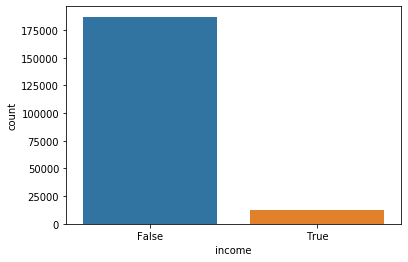

In [16]:
sns.countplot(x='income', data=df)

#### 3.2 : Define the metric used to evaluate model performance.

In [17]:
def evaluate_metrics(y_predict, y_test):
    """
    This function computes various model evaluation metrics for given data set.
    input: Arrays of true and predicted values.
    output: results of various metrics.
    
    """
    
    result = {}
    f1 = f1_score(y_test, y_predict)
    p = precision_score(y_test,y_predict)
    r = recall_score(y_test,y_predict)
    a = roc_auc_score(y_test,y_predict)
    c = confusion_matrix(y_test,y_predict)

    print ("F1 Score         : ", f1)
    print ("Precission Score : ", p)
    print ("Recall Score     : ", r)
    print ("roc_auc_score    : ",a )
    print ("Confusion Matrix : ",c)
    
    result['f1'] = f1
    result['p'] = p
    result['r'] = r
    result['a'] = a
    result['c'] = c
    
    return result

#### 3.3 Oversampling of minority class

In [18]:
from sklearn.utils import resample
def overample_minority(df, alpha):
    """
        This function oversamples the minority class to balance both the classes in the dataset.
        input: a dataframewith imbalanced classed.
        output: modified dataframe with balanced classes.
    """
    
# separate minority and majority classes
    above = df[df.income == True ]
    below = df[df.income == False]
    
    # upsample minority
    above_upsampled = resample(above,
                        replace=True, # sample with replacement
                        n_samples=int(len(below)/alpha), # match number in majority class
                        random_state=42) # reproducible results

    # combine majority and upsampled minority
    upsampled = pd.concat([above_upsampled, below])
    
    # check new class counts
    print(upsampled.income.value_counts())
  
    return upsampled

In [19]:
df_true = df[df.income == True]
df_false = df[df.income == False]
print ("Imabanced data set",(len(df_true)/ len(df))  * 100, "%" )

x=overample_minority(df,4)
x_true = x[x.income == True]
x_false = x[x.income == False]
print ("Imabanced data set",(len(x_true)/ len(x))  * 100, "%" )

Imabanced data set 6.205800834991455 %
False    187141
True      46785
Name: income, dtype: int64
Imabanced data set 19.99991450287698 %


### 4.  Data Exploration

#### 4.1  Is there any imbalance between different sexes in majority and minority classes.

<p> Looking at the chart below, in both the Sexes, the difference between both classes are approximately similar.

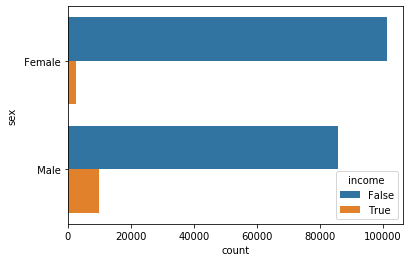

In [20]:
sns.countplot(y='sex',hue='income',data=df, order = df['sex'].value_counts().iloc[:10].index,orient='v')

#### 4.2 what is the impact of education on the income earned by an individual?

Following conclusions can be derived from the below charts

1. Children have a very less probability of earning more than 50k income. Hence these data points can be safely removed for training the model.

2. Maximum number of individuals earning income more than 50k have Bachelor's degree.

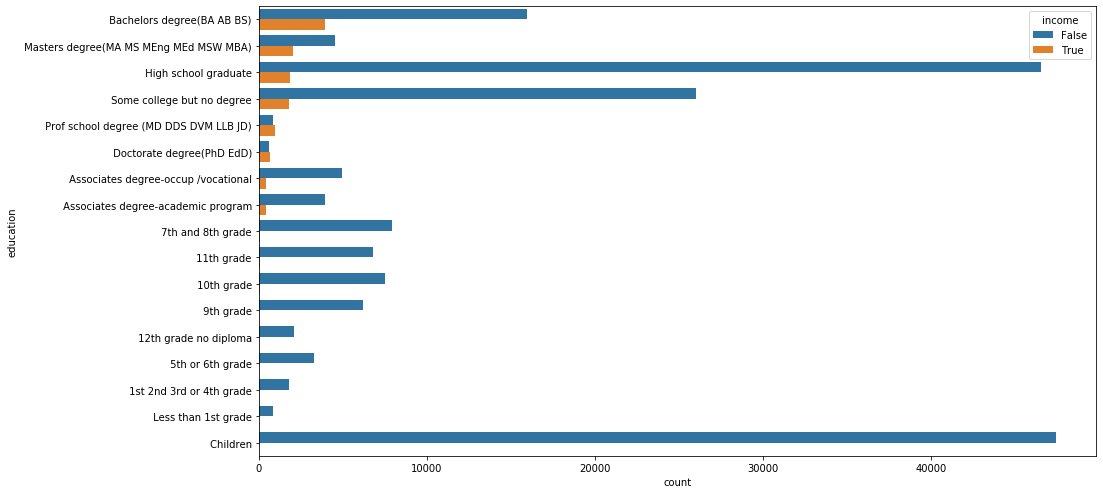

In [21]:
a4_dims = (15, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.countplot(y='education',hue='income',data=df, order = df_true['education'].value_counts().index,orient='v')

####  Remove entries for children

In [22]:
df = df[df.education != ' Children']
df_test = df_test[df_test.education != ' Children']

In [23]:
#Imbalance of the data reduced to aprox 8%
df_true = df[df.income == True]
df_false = df[df.income == False]
print ("Imabanced data set",(len(df_true)/ len(df))  * 100, "%" )

Imabanced data set 8.140643388274896 %


#### 4.3 Check for any corelation between race and income

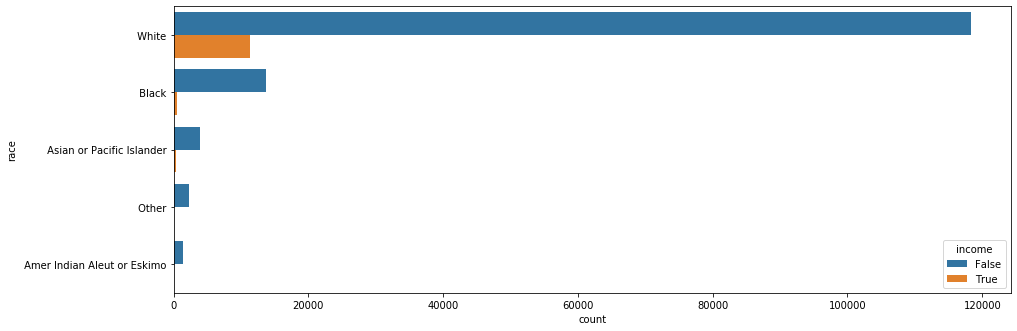

In [24]:
a4_dims = (15, 5.27)
fig, ax = plt.subplots(figsize=a4_dims)
#sns.countplot(y='race',hue='income',data=df_true, order = df_true['race'].value_counts().index,orient='v')
sns.countplot(y='race',hue='income',data=df, order = df['race'].value_counts().iloc[:10].index,orient='v')

#### 4.4 Check for any corelation between various categorical variables and income

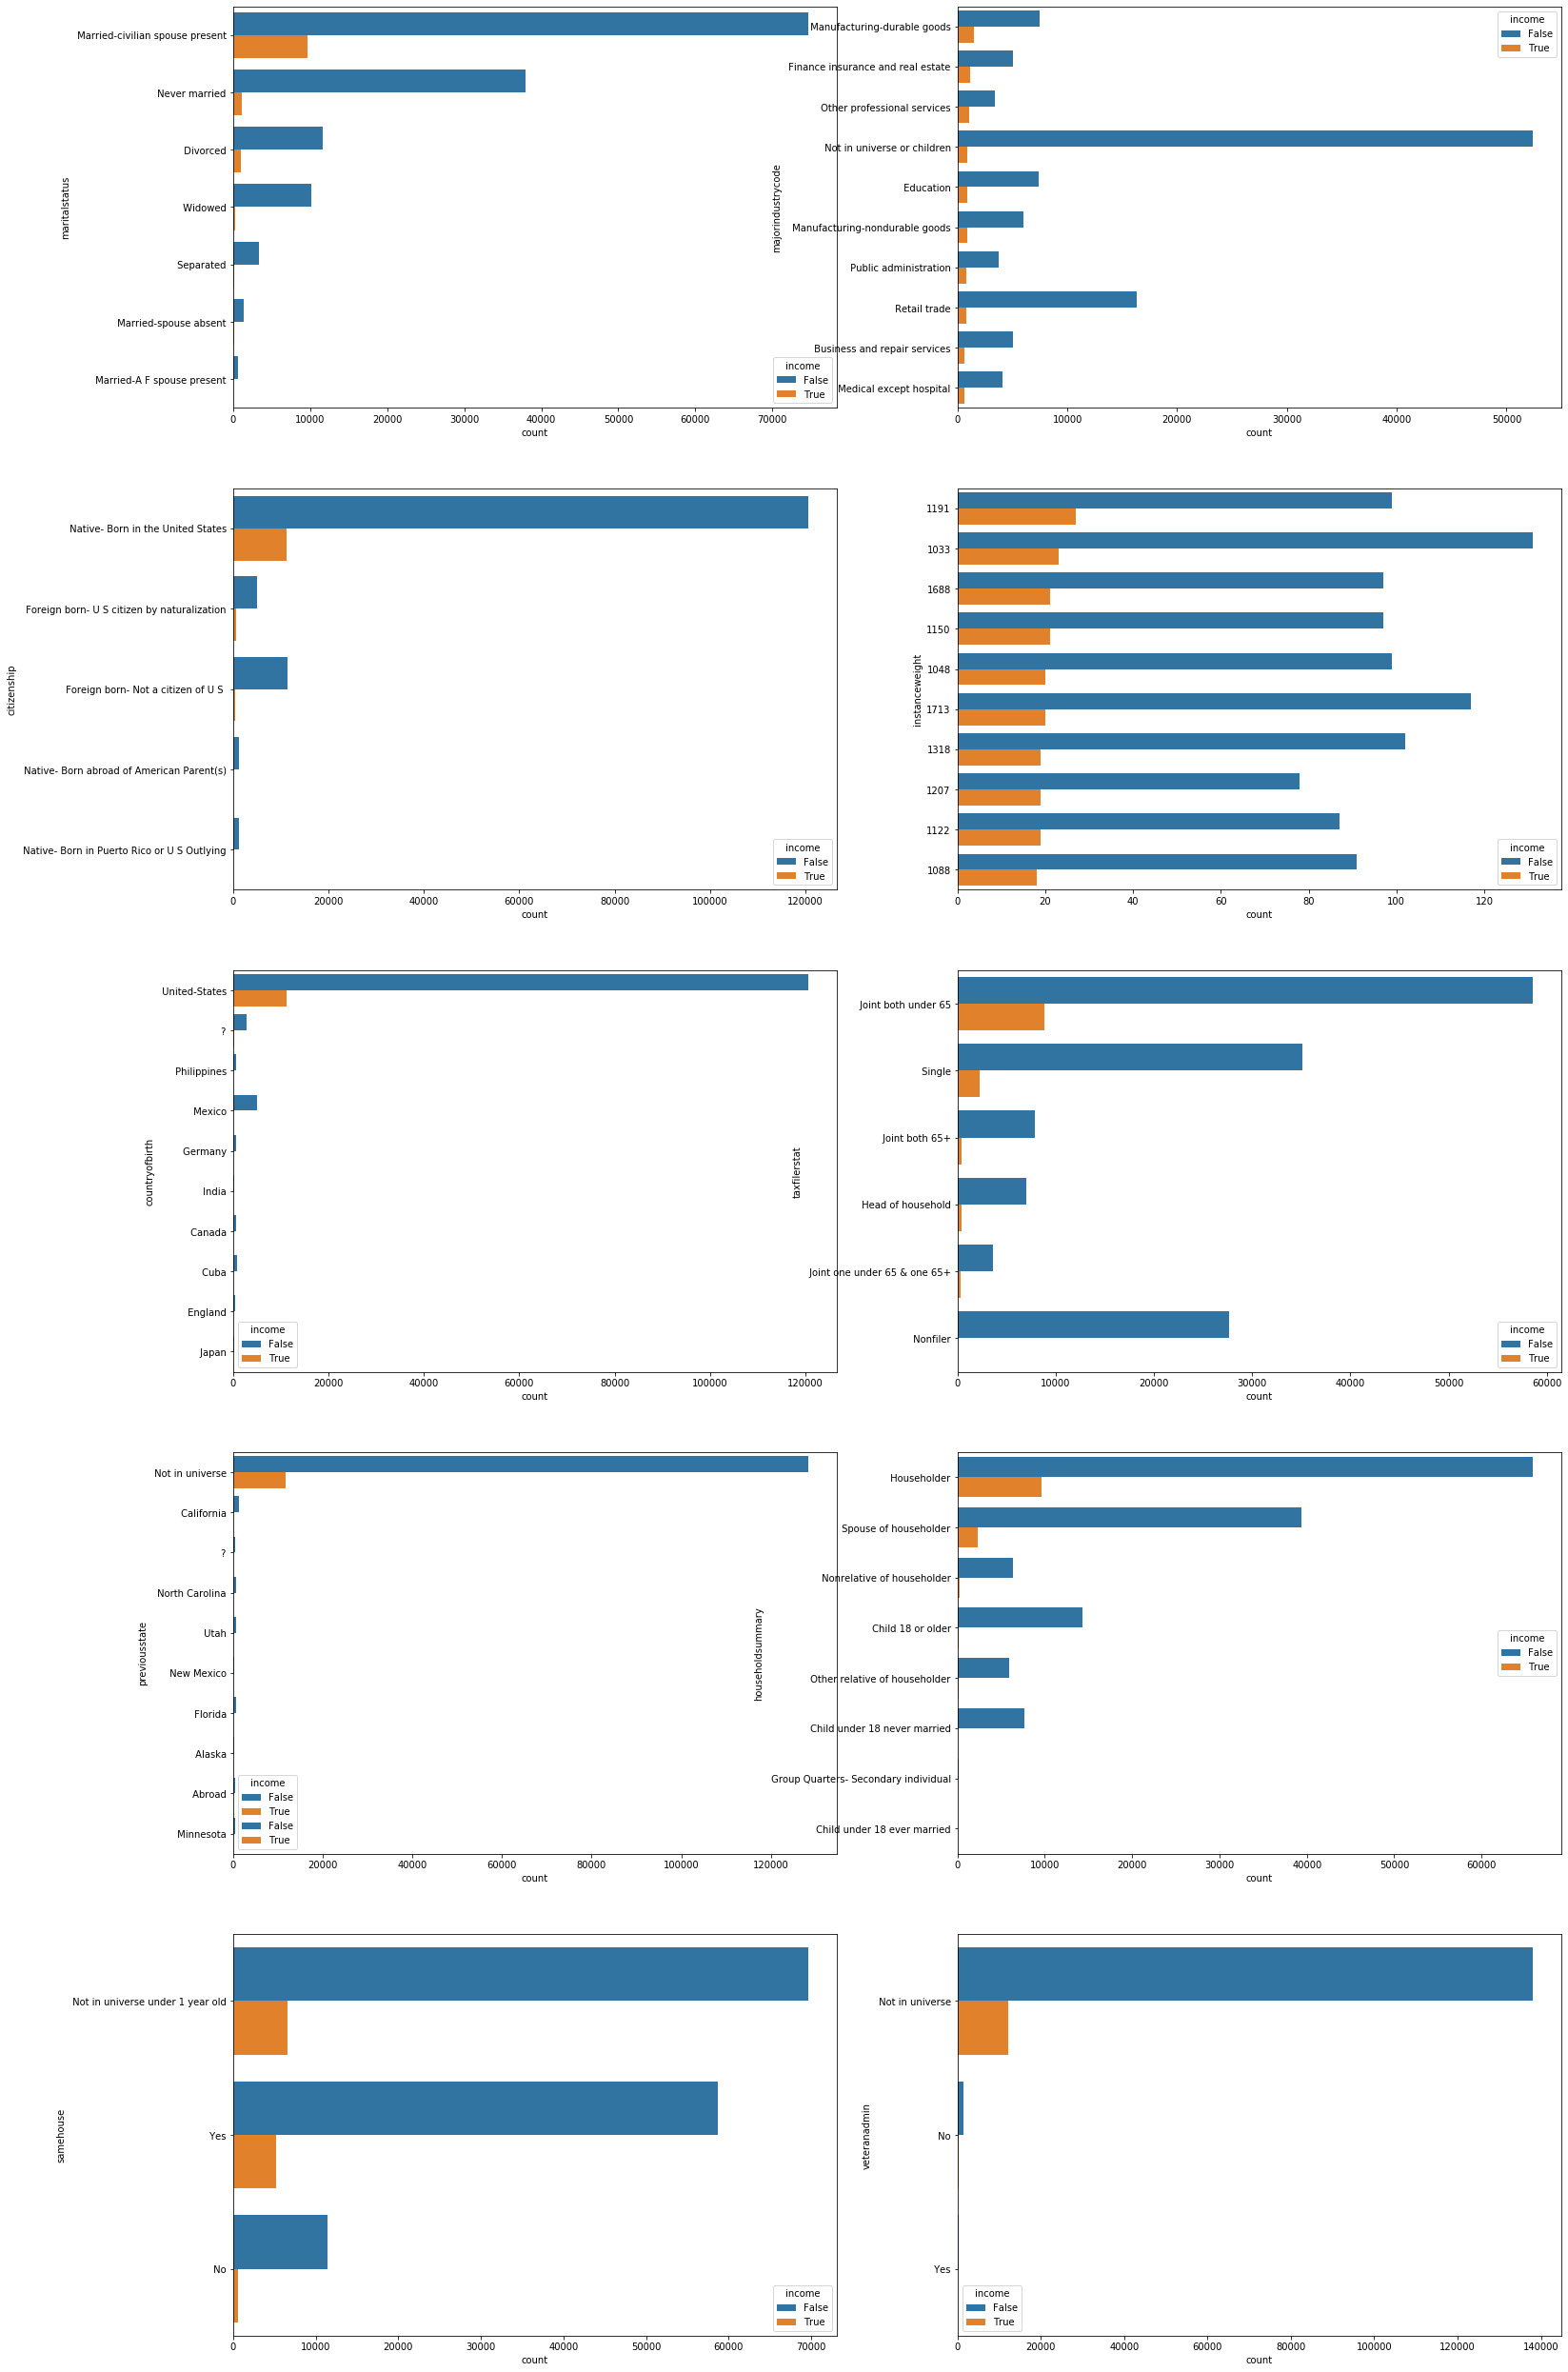

In [25]:
a4_dims = (25, 45)
fig, ax = plt.subplots(5,2,figsize=a4_dims)
sns.countplot(y='maritalstatus',hue='income',data=df, order = df_true['maritalstatus'].value_counts().iloc[:10].index,ax=ax[0, 0])
sns.countplot(y='majorindustrycode',hue='income',data=df, order = df_true['majorindustrycode'].value_counts().iloc[:10].index,ax=ax[0,1])
sns.countplot(y='citizenship',hue='income',data=df, order = df_true['citizenship'].value_counts().iloc[:10].index,ax=ax[1,0])
sns.countplot(y='instanceweight',hue='income',data=df, order = df_true['instanceweight'].value_counts().iloc[:10].index,ax=ax[1,1])
sns.countplot(y='countryofbirth',hue='income',data=df, order = df_true['countryofbirth'].value_counts().iloc[:10].index,ax=ax[2,0])
sns.countplot(y='taxfilerstat',hue='income',data=df, order = df_true['taxfilerstat'].value_counts().iloc[:10].index,ax=ax[2,1])
sns.countplot(y='previousstate',hue='income',data=df, order = df_true['previousstate'].value_counts().iloc[:10].index,ax=ax[3,0])
sns.countplot(y='householdsummary',hue='income',data=df, order = df_true['householdsummary'].value_counts().iloc[:10].index,ax=ax[3,1])
sns.countplot(y='previousstate',hue='income',data=df, order = df_true['previousstate'].value_counts().iloc[:10].index,ax=ax[3,0])
sns.countplot(y='samehouse',hue='income',data=df, order = df_true['samehouse'].value_counts().iloc[:10].index,ax=ax[4,0])
sns.countplot(y='veteranadmin',hue='income',data=df, order = df_true['veteranadmin'].value_counts().iloc[:10].index,ax=ax[4,1])

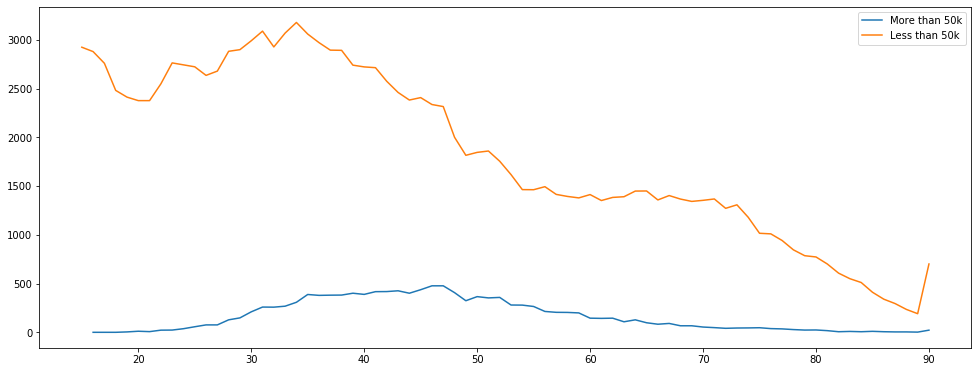

In [26]:
a4_dims = (16.7, 6.27)
fig, ax = plt.subplots(figsize=a4_dims)
f = df_false['age'].value_counts()
s = df_true['age'].value_counts()
_ = sns.lineplot(x=s.index,y=s.values,label='More than 50k')
_ = sns.lineplot(x=f.index,y=f.values,label='Less than 50k')
plt.show()

### Check for Stock dividends, Capital Gains and Losses

/home/sdchavm/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/sdchavm/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


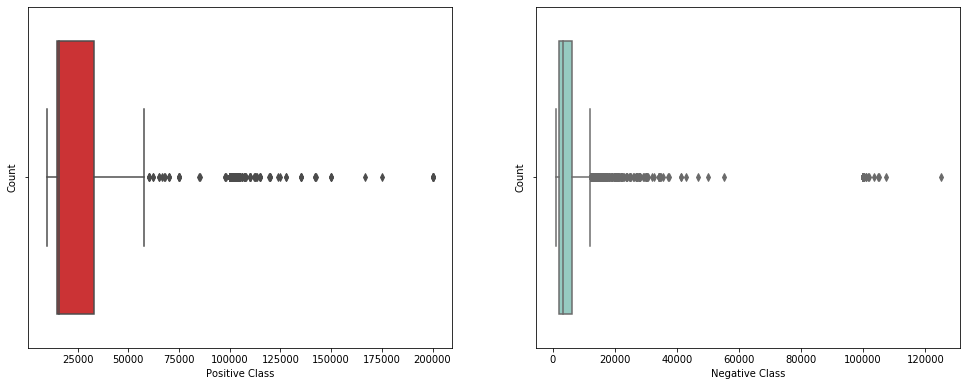

In [27]:
df_true = df[df.income == True]
df_false = df[df.income == False]
a4_dims = (16.7, 6.27)
fig, axes = plt.subplots(1,2,figsize=a4_dims)
df_true['total'] = df_true.capttaingain + df_true.stockdivdend  - df_true.capitalloss
df_false['total'] = df_false.capttaingain + df_false.stockdivdend - df_false.capitalloss

sns.boxplot(df_true.total[df_true.total > 10000 ], ax=axes[0],palette="Set1")
sns.boxplot(df_false.total[df_false.total > 1000 ], ax=axes[1],palette="Set3")
axes[0].set(xlabel='Positive Class', ylabel='Count')
axes[1].set(xlabel='Negative Class', ylabel='Count')

df_true = df_true.drop(columns = ['total', 'capttaingain','stockdivdend','capitalloss','instanceweight'])
df_false = df_false.drop(columns = ['total', 'capttaingain','stockdivdend','capitalloss','instanceweight'])

df = df.drop(columns = [ 'capttaingain','stockdivdend','capitalloss','instanceweight'])
df_test = df_test.drop(columns = [ 'capttaingain','stockdivdend','capitalloss','instanceweight'])

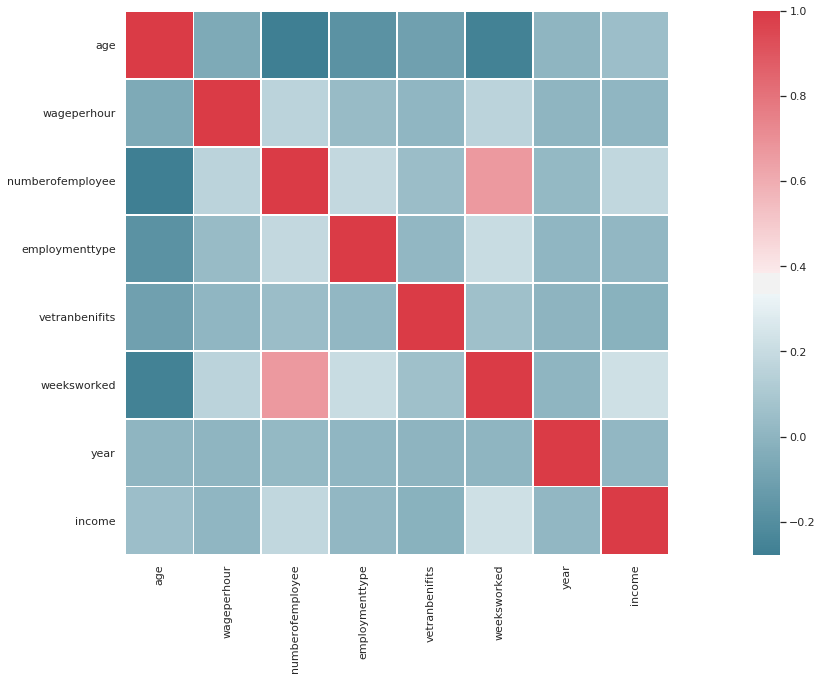

In [28]:
sns.set(style="white")
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
#mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(30, 10))

# Draw the heatmap with the mask and correct aspect ratio
_ = sns.heatmap(corr, mask=mask, cmap=cmap , square=True, linewidths=.5, ax=ax)

### 5. Create Test,Train and Validation dataset

#### 5.1  One hot encoding

Since most of the fields in the dataset are categorical variables, sklearn does not handle categorical variables. One-hot encoders convert categorical variables into integers

In [29]:
def dummy_encode (df,df_test):
    """
    This function concats train and test dataset.  Converts the combined dataset for one hot encoding.
    The function returns the split train and test dataset.
    input parameters: trainset , testset.
    output parameters: one hot encoded train and test sets
    """
    df['Type'] = True
    df_test['Type'] = False
    combined_df = pd.concat([df,df_test])
    combinded_X = combined_df.loc[:, df.columns != 'income']
    combined_y = combined_df.income
    combined_df = pd.get_dummies(combinded_X, prefix_sep='__', columns=cat_cols)
    combined_df['income'] = combined_y
    df_new = combined_df[combined_df.Type == True]
    df_test_new = combined_df[combined_df.Type == False]
    df_new = df_new.drop(columns=['Type'])
    df_test_new = df_test_new.drop(columns=['Type'])
    df = df.drop(columns=['Type'])
    df_test.drop(columns=['Type'])
    return df_new, df_test_new

In [30]:
df_en, df_test_en = dummy_encode (df,df_test)

#### New dimensions of the data are

In [31]:
print(df_en.shape)
print(df_test_en.shape)

(152101, 503)
(76320, 503)


In [32]:
df_en_y = df_en['income']
df_en_X = df_en.drop(columns=['income'])

In [33]:
df_test_en_y = df_test_en['income']
df_test_en_X = df_test_en.drop(columns=['income'])

In [34]:
print(df_test_en_X.shape)
print(df_test_en_y.shape)

(76320, 502)
(76320,)


#### 5.2 Create a test and train data set from the df_en

In [35]:
X_en_train, X_en_test, y_en_train,y_en_test = train_test_split(df_en_X,df_en_y, random_state = 42, test_size =0.3)

####  5.3 Create default classifier 

In [36]:
names = ['RandomForestClassifier','AdaBoostClassifier','GaussianNB','GradientBoostingClassifier']
classifiers = [
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    GradientBoostingClassifier()
   ]

In [37]:
def find_classifier(names, classifiers,X_en_train,y_en_train,X_en_test,y_en_test,df_test_en_X,df_test_en_y):
    validation_metric = {}
    test_metric = {}
    print(names)
    for name, clf in zip(names, classifiers):
        print(name)
        clf.fit(X_en_train,y_en_train)
        y_en_predict = clf.predict(X_en_test)
        print("Validation Metrics :")
        validation_metric[name] = evaluate_metrics(y_en_test, y_en_predict)
        
        print("Test Metrics  :")
        y_df_predict = clf.predict(df_test_en_X)
        test_metric[name] = evaluate_metrics(df_test_en_y,y_df_predict)
      
    return validation_metric, test_metric

In [38]:
x,y = find_classifier(names,classifiers,X_en_train,y_en_train,X_en_test,y_en_test,df_test_en_X,df_test_en_y)

['RandomForestClassifier', 'AdaBoostClassifier', 'GaussianNB', 'GradientBoostingClassifier']
RandomForestClassifier
Validation Metrics :
F1 Score         :  0.4304884594739667
Precission Score :  0.322260916153228
Recall Score     :  0.6481681034482759
roc_auc_score    :  0.7951862790228243
Confusion Matrix :  [[41245  2530]
 [  653  1203]]
Test Metrics  :
F1 Score         :  0.4188925081433224
Precission Score :  0.3118331716779825
Recall Score     :  0.6378968253968254
roc_auc_score    :  0.7899086288084324
Confusion Matrix :  [[69039  4257]
 [ 1095  1929]]
AdaBoostClassifier
Validation Metrics :
F1 Score         :  0.44396474186004675
Precission Score :  0.330565229038307
Recall Score     :  0.6757940854326396
roc_auc_score    :  0.8093729016365344
Confusion Matrix :  [[41306  2499]
 [  592  1234]]
Test Metrics  :
F1 Score         :  0.44477965736450814
Precission Score :  0.33365664403491757
Recall Score     :  0.6668820678513732
roc_auc_score    :  0.8052949089683632
Confusion Mat

In [39]:
classifiers[3]

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [40]:
importance = classifiers[3].feature_importances_
indices = importance.argsort()[::-1][:10]
features = X_en_train.columns
top_features = []
for i in indices[:20]:
    print(features[i])

weeksworked
age
majoroccode__ Executive admin and managerial
sex__ Female
majoroccode__ Professional specialty
sex__ Male
education__ Masters degree(MA MS MEng MEd MSW MBA)
education__ Prof school degree (MD DDS DVM LLB JD)
education__ Bachelors degree(BA AB BS)
education__ Doctorate degree(PhD EdD)


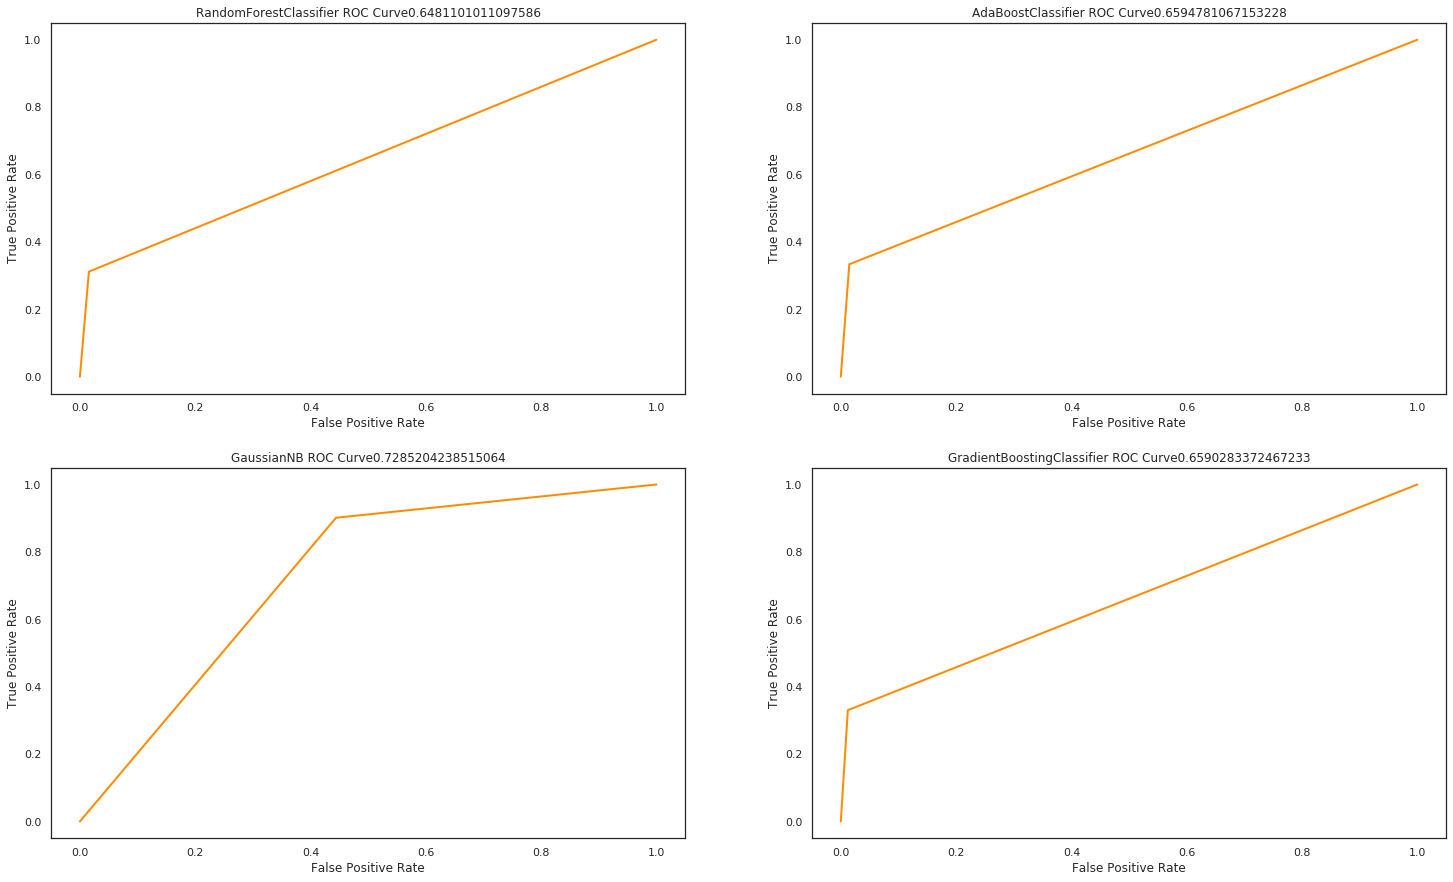

In [41]:
a4_dims = (25, 15)
fig, ax = plt.subplots(2,2,figsize=a4_dims)
aux = [[0,0],[0,1],[1,0],[1,1]]
lw=2
for i in range(0,len(classifiers)):
    y_predict = classifiers[i].predict(df_test_en_X)
    fpr,tpr,_ = roc_curve(df_test_en_y,y_predict)
    roc_auc = auc(fpr, tpr)
    x = aux[i][0]
    y = aux[i][1]
    ax[x,y].plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    ax[x,y].set(xlabel='False Positive Rate',ylabel="True Positive Rate")
    ax[x,y].set_title(names[i] + " ROC Curve" +  str(roc_auc))
  

### 6. Tunning the default model

The default model can be furtuer tuned to increase the performance.

#### 6.1 Oversampling the minority class

In [42]:
#Over Sample Minority class
ov_df = overample_minority(df,8)

False    139719
True      17464
Name: income, dtype: int64


In [43]:
ov_df_true = ov_df[ov_df.income == True]
ov_df_false = ov_df[ov_df.income == False]
print ("Imabanced data set",(len(ov_df_true)/ len(ov_df))  * 100, "%" )

Imabanced data set 11.11061628802097 %


#### 6.2  One hot encoding for the reshuffled data.

In [44]:
ov_df_en, ov_df_test_en = dummy_encode (ov_df,df_test)

In [45]:
ov_df_test_en_y = ov_df_test_en['income']
ov_df_test_en_X = ov_df_test_en.drop(columns=['income'])
ov_df_en_y = ov_df_en['income']
ov_df_en_X = ov_df_en.drop(columns=['income'])

#### 6.3 Hyper Parameter tuning using GridSearchCV

In [46]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_features': [2, 3,4],
    'min_samples_leaf': [1, 2,3,4],
    'min_samples_split': [1,2,3,5],
    'n_estimators': [50,100,150,300,1000 ]
}

# Create a based model
rf = GradientBoostingClassifier()
#Scoring
scorings = {'AUC': 'roc_auc', 'F1': 'f1'}


# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, 
                               verbose = 2, scoring=scorings, refit='AUC', return_train_score=True)

In [47]:
ov_X_en_train, ov_X_en_test, ov_y_en_train,ov_y_en_test = \
                train_test_split(ov_df_en_X,ov_df_en_y, random_state = 42, test_size =0.3, stratify=ov_df_en_y)

In [48]:
grid_search.fit(ov_X_en_train, ov_y_en_train)

Fitting 3 folds for each of 240 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   52.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed: 14.0min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed: 26.3min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 30.5min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_c...
                 

In [49]:
best = grid_search.best_params_
results = grid_search.cv_results_
print(best)

{'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}


In [50]:
clf = GradientBoostingClassifier(
                             max_features=best['max_features'], min_samples_leaf=best['min_samples_leaf'],
                            min_samples_split=best['min_samples_split'], n_estimators=best['n_estimators'])

In [51]:
clf.fit(ov_X_en_train, ov_y_en_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=4, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=1000,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [54]:
importance = clf.feature_importances_
indices = importance.argsort()[::-1][:10]
features = ov_X_en_train.columns
top_features = []
for i in indices[:20]:
    print(features[i])

occupationcode__2
sex__ Male
education__ Masters degree(MA MS MEng MEd MSW MBA)
age
education__ Prof school degree (MD DDS DVM LLB JD)
numberofemployee
sex__ Female
education__ Doctorate degree(PhD EdD)
education__ Bachelors degree(BA AB BS)
occupationcode__7


In [55]:
x = clf.predict(ov_X_en_test)
evaluate_metrics( ov_y_en_test,x)
f1 = f1_score(x, ov_y_en_test)
print(f1)

F1 Score         :  0.541153753318851
Precission Score :  0.427944264172552
Recall Score     :  0.7358057105349524
roc_auc_score    :  0.8339294264110328
Confusion Matrix :  [[41111  2997]
 [  805  2242]]
0.541153753318851


In [56]:
ov_y_en_predict_df_test = clf.predict(ov_df_test_en_X)
evaluate_metrics(ov_df_test_en_y, ov_y_en_predict_df_test)

F1 Score         :  0.49886217473038486
Precission Score :  0.4075331393469124
Recall Score     :  0.6429482274929865
roc_auc_score    :  0.7961629906646828
Confusion Matrix :  [[68734  3665]
 [ 1400  2521]]


{'f1': 0.49886217473038486,
 'p': 0.4075331393469124,
 'r': 0.6429482274929865,
 'a': 0.7961629906646828,
 'c': array([[68734,  3665],
        [ 1400,  2521]])}

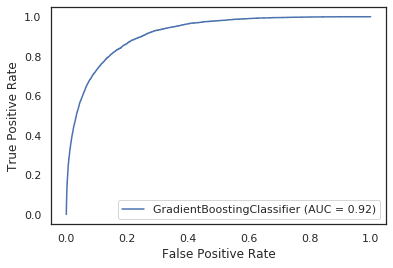

In [57]:
plot_roc_curve(clf,ov_df_test_en_X,ov_df_test_en_y)

In [58]:
from imblearn.over_sampling import SMOTE

In [59]:
# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(df_en_X, df_en_y, test_size=0.25, random_state=42)

In [60]:
sm = SMOTE(random_state=42)

In [61]:
X_train, y_train = sm.fit_sample(X_train, y_train)

In [62]:
clf = GradientBoostingClassifier(
                             max_features=best['max_features'], min_samples_leaf=best['min_samples_leaf'],
                            min_samples_split=best['min_samples_split'], n_estimators=best['n_estimators'])

In [63]:
clf.fit(X_train,y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=4, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=3,
                           min_weight_fraction_leaf=0.0, n_estimators=1000,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [64]:
y_en_predict = clf.predict(X_test)
evaluate_metrics(y_test, y_en_predict)

F1 Score         :  0.5183691110790952
Precission Score :  0.579015127132282
Recall Score     :  0.4692227438706312
roc_auc_score    :  0.7154840906999388
Confusion Matrix :  [[32884  1308]
 [ 2035  1799]]


{'f1': 0.5183691110790952,
 'p': 0.579015127132282,
 'r': 0.4692227438706312,
 'a': 0.7154840906999388,
 'c': array([[32884,  1308],
        [ 2035,  1799]])}

In [65]:
y_en_predict = clf.predict(df_test_en_X)
evaluate_metrics(df_test_en_y, y_en_predict)

F1 Score         :  0.517641934078699
Precission Score :  0.5763013255738765
Recall Score     :  0.4698207696362678
roc_auc_score    :  0.715843574598731
Confusion Matrix :  [[66111  2621]
 [ 4023  3565]]


{'f1': 0.517641934078699,
 'p': 0.5763013255738765,
 'r': 0.4698207696362678,
 'a': 0.715843574598731,
 'c': array([[66111,  2621],
        [ 4023,  3565]])}

### Conclusion


From the raw data only 6% percent of individuals have income greater than $50k. When faced with imbalanced data sets there is no one stop solution to improve the accuracy of the prediction model.  One may need to try out multiple methods to figure out the best-suited sampling techniques for the dataset. The model will help marketing deparment target potential customers with Higher precission and recall.


